# Generates EMG Forward Solution using MNE-Python #
This notebook generates the forward solution, which is used in the inverse part (other notebook) to get the source localization given some empirical data.  

## Python Imports ##
Use `venv` to create a virtual environment (naming it `.venv` will make your code more-compatible with the default repository settings in `.vscode` under `settings.json` and `tasks.json`). After you initially create your virtual environment, then activate it and use `python -m pip install -r requirements.txt` to ensure you have the correct Python libraries.  

In [16]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.forward import make_forward_solution, compute_orient_prior
from pathlib import Path
import pymeshfix
import scipy
import pandas as pd
from scipy.spatial import ConvexHull, Delaunay
from mpl_toolkits.mplot3d import Axes3D
import pyvistaqt
from geometry_utilities import *
from bem_arm_patch import _surfaces_to_bem_no_size_check

%matplotlib inline

## Set Parameters Here ##
### Conductivities ###
We use muscle, skin, and fat conductivities measured at 100-Hz, taken from https://itis.swiss/virtual-population/tissue-properties/database/dielectric-properties/.  

### Minimum Dipole Distance ###
We ran models with 2-mm, 5-mm, and 7-mm grids. The 2-mm model produces >20,000 dipoles. The 5-mm model produces ~1,600 dipoles. The 7-mm model produces ~230 dipoles.   

In [17]:
# Set conductivity and paths
CONDUCTIVITY = (2.67e-1, 4.06e-2, 2e-4,) # muscle, fat, skin
MIN_DIPOLE_DISTANCE = 2.0 # mm
# NUM_ELECTRODES = 128 # e.g. for Pok model
NUM_ELECTRODES = 256 # e.g. for "Coverage" models

# Does not actually require freesurfer installed, this is just the path to the directory
SUBJECT = "simp_arm"
ARM = "left"
# ARM = "right"

SAMPLE_RATE = 2000. # Samples/Second

# SUBJECTS_DIR = Path('/Applications/freesurfer/7.3.2/subjects') # Pok
SUBJECTS_DIR = Path('Data/subjects')
BEM_DIR = SUBJECTS_DIR / SUBJECT / "bem"
SKIN_FILENAME = "Data/Blender/Outer_skin.obj"
FAT_FILENAME = "Data/Blender/Outer_fat.obj"
MUSCLE_FILENAME = "Data/Blender/Outer_muscle.obj"
DENSE_SKIN_FILENAME = "Data/Blender/Outer_skin_denseT.obj"
BEM_ARM_MODEL = "Data/bem_simp_arm"
FIX_DENSE_MESH_TOPOLOGY = False
BUILD_MODEL_FROM_MESHES = False
ELECTRODE_POSITION_CSV = f"{NUM_ELECTRODES}arm_electrode_pos.csv"

## Import Mesh Geometries ## 
To create the forward model we have to have some fundamental representation of the geometry as a mesh or surface etc. For more nuanced/complicated/accurate geometries, it typically means a lot more mesh vertices and correspondingly terrible compute times. 

In [18]:
# Convert .obj files into MNE-named surfaces
# SKIN_FILENAME = "/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/Blender/Outer_skin.obj"
coords, faces = mne.read_surface(SKIN_FILENAME)
mne.write_surface(BEM_DIR / 'outer_skin.surf', coords, faces, overwrite=True)

# FAT_FILENAME = "/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/Blender/Outer_fat.obj"
coords, faces = mne.read_surface(FAT_FILENAME)
mne.write_surface(BEM_DIR / 'outer_skull.surf', coords, faces, overwrite=True)

# MUSCLE_FILENAME = "/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/Blender/Outer_muscle.obj"
coords, faces = mne.read_surface(MUSCLE_FILENAME)
mne.write_surface(BEM_DIR / 'inner_skull.surf', coords, faces, overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


## (Optional) Fix dense mesh topologies ##
Realistic mesh models have very-dense mesh topologies and sometimes the Blender export does not create properly formed meshes. We can optionally use `pymeshfix` to clean up the meshes a little bit, if necessary. 

In [19]:
# If cleaning is required / if meshes have topological errors, can use pymeshfix
if FIX_DENSE_MESH_TOPOLOGY:
    # DENSE_SKIN_FILENAME = "/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/Blender/Outer_skin_denseT.obj"
    coords, faces = mne.read_surface(DENSE_SKIN_FILENAME)
    mne.write_surface(BEM_DIR / 'inner_skull.surf', coords, faces, overwrite=True)
    coords, faces = pymeshfix.clean_from_arrays(coords, faces)
    coords = coords - coords.mean(axis=0)
    coords = coords / 1000  # Seems to be given in milimetres as, convert to meters
    mne.write_surface(BEM_DIR / 'inner_skull.surf', coords, faces, overwrite=True)

## (Optional) Build model from fixed meshes ##
If we have manually made some new meshes or need to redo this part, we can set the `BUILD_MODEL_FROM_MESHES` flag to `True` and run it here. Otherwise skip this part as it takes a long-ish time. 

In [20]:
if BUILD_MODEL_FROM_MESHES:
    mne.bem._surfaces_to_bem = _surfaces_to_bem_no_size_check
    model = mne.make_bem_model(subject=SUBJECT, subjects_dir=SUBJECTS_DIR, ico=None, conductivity=CONDUCTIVITY, verbose=None)
    bem = mne.make_bem_solution(model,) # does not work with openmeeg, use MNE-Python's default BEM solver instead 
    mne.write_bem_solution("Data/bem_simp_arm.h5", bem, overwrite=False, verbose=None)
else:
    bem = mne.read_bem_solution(BEM_ARM_MODEL)

Three-layer model surfaces loaded.
Loaded linear collocation BEM solution from c:\MyRepos\Python\CMU_EMGSL\Data\bem_simp_arm


## Construct Source Space ##
In this step, we need to set up a source space grid with a given resolution and also specify what models go in as sources (we use dipoles with a prior on the orientation). Basically the key parameter in this case ends up being `MIN_DIPOLE_DISTANCE` which defines our grid spacing in the source space.

In [21]:
# Construct source space.  Adjust pos parameter to change the spacing between dipole sources.  Somewhere between 2mm and 5mm is sensible (~1,600 -> ~25,000 dipoles)
src = mne.setup_volume_source_space(subject=None, pos=MIN_DIPOLE_DISTANCE, mri=None, bem=bem, mindist=MIN_DIPOLE_DISTANCE, )
src.plot(skull=False) # View the source space 3D model to sanity check orientation etc.

BEM              : <ConductorModel | BEM (3 layers) solver=mne>
grid                  : 2.0 mm
mindist               : 2.0 mm

Taking inner skull from <ConductorModel | BEM (3 layers) solver=mne>
Surface CM = (   0.0   -0.0   85.1) mm
Surface fits inside a sphere with radius   87.3 mm
Surface extent:
    x =  -21.6 ...   21.6 mm
    y =  -21.6 ...   21.6 mm
    z =    0.1 ...  169.8 mm
Grid extent:
    x =  -22.0 ...   22.0 mm
    y =  -22.0 ...   22.0 mm
    z =    2.0 ...  170.0 mm
44965 sources before omitting any.
44713 sources after omitting infeasible sources not within 0.0 - 87.3 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    2.0 mm away (will take a few...)
Checking surface interior status for 44713 points...
    Found  3984/44713 points inside  an interior sphere of radius   19.7 mm
    Found     0/44713 points outside an exterior sphere of radius   87.3 mm
    Found 18749/40729 points outside using surface Qhull
    

In [22]:
# Load electrode positions and move towards the skin surface
elec_pos_df = pd.read_csv(ELECTRODE_POSITION_CSV, )

# Outer skin surface
pos, _ = mne.read_surface(SKIN_FILENAME)
pos = pos/1000

# Clearly it's easier to adjust the electrode positions at this point, rather than the source space
# So adjust axes - Should save it in a better order in Blender...
electrode_pos = elec_pos_df[["X", "Y", "Z"]].to_numpy()
# Then adjust translations for X and Y
electrode_pos[:, 0] = electrode_pos[:, 0] - electrode_pos[:,0].mean()
electrode_pos[:, 1] = electrode_pos[:, 1] - electrode_pos[:, 1].mean()
# Since electrode pos was mapped for left arm, swap x axis (where x-axis is along the electrodes) - Index 0 is correct as confirmed with the plot of source space and convex hull below.
if ARM == "left":
    electrode_pos[:, 1] = -electrode_pos[:, 1]
    print("Mirrored electrodes for left-arm geometry.")

In [23]:
print(electrode_pos.max(axis=0))
print(electrode_pos.min(axis=0))
print(electrode_pos.mean(axis=0))
print(np.median(electrode_pos, axis=0))
print('src below')  # src['rr'] includes points not used, so need to adjust
print(src[0]['rr'].max(axis=0))
print(src[0]['rr'].min(axis=0))
print(src[0]['rr'].mean(axis=0))
print(np.median(src[0]['rr'], axis=0))
print('Outer skin below')
print(pos.max(axis=0))
print(pos.min(axis=0))
print(pos.mean(axis=0))
print(np.median(pos, axis=0))

elec_pos_df

[0.0356513  0.02974603 0.1575    ]
[-0.03179992 -0.02458376  0.        ]
[ 3.63207728e-18 -1.17093835e-17  7.76704242e-02]
[-0.00311511 -0.00044466  0.07442307]
src below
[0.022 0.022 0.17 ]
[-0.022 -0.022  0.002]
[-5.75604899e-20 -1.07652005e-18  8.60000000e-02]
[0.    0.    0.086]
Outer skin below
[0.02886069 0.02886069 0.17      ]
[-0.02886069 -0.02886069  0.        ]
[3.28774320e-10 2.98264057e-10 8.51738242e-02]
[0.       0.       0.085175]


,X,Y,Z,RowColumn,Channel,Ch_num,Patch
0,0.027149,0.105739,2.596876e-06,R1C8,UNI 01,1,1
1,0.027056,0.105727,8.747513e-03,R2C8,UNI 02,2,1
2,0.027073,0.105645,1.751074e-02,R3C8,UNI 03,3,1
3,0.027503,0.105588,2.638230e-02,R4C8,UNI 04,4,1
4,0.020558,0.099517,9.829182e-07,R1C7,UNI 05,5,1
...,...,...,...,...,...,...,...
123,0.065396,0.098291,1.227922e-01,R8C7,UNI 60,60,4
124,0.051508,0.095327,1.574933e-01,R5C8,UNI 61,61,4
125,0.052548,0.096637,1.488152e-01,R6C8,UNI 62,62,4
126,0.053588,0.097948,1.401372e-01,R7C8,UNI 63,63,4


In [24]:
# Move electrodes to surface of skin
hull = ConvexHull(pos)

# Create a Delaunay triangulation of the convex hull vertices
tri = Delaunay(pos[hull.vertices])

# Extract the vertices of the convex hull
hull_points = pos[hull.vertices]

# Move all points in electrode_pos to the closest point on the convex hull surface
electrode_pos = np.array([closest_point_on_hull(hull, point) for point in electrode_pos])

C:\Users\maxmu\AppData\Local\Temp\ipykernel_158068\2387602379.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


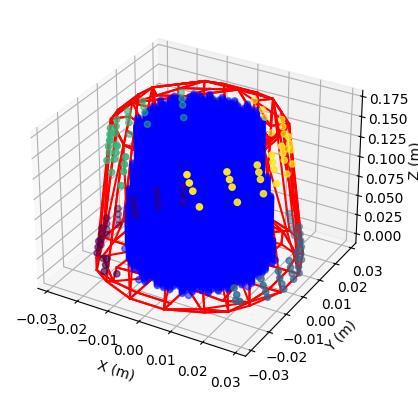

In [25]:
# Plot the convex hull and the moved points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the convex hull
for simplex in hull.simplices:
    ax.plot(pos[simplex, 0], pos[simplex, 1], pos[simplex, 2], 'r-')
# Plot the moved points on the hull
ax.scatter(electrode_pos[:, 0], electrode_pos[:, 1], electrode_pos[:, 2], c=elec_pos_df["Patch"], marker='o')
# Plot the source space
ax.scatter(src[0]["rr"][src[0]["vertno"], 0], src[0]["rr"][src[0]["vertno"], 1], src[0]["rr"][src[0]["vertno"], 2], c='b', marker='o', alpha=0.5)
# Set labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
fig.show()

In [26]:
# Save new electrode positions
np.save(f"Data/{NUM_ELECTRODES}simparm-{ARM}_electrode_pos.npy", electrode_pos)

In [27]:
# Create info structure with EMG electrode channel names
ch_names = ['EMG ' + str(i) + '-' +str(j) for i, j in zip(elec_pos_df['Patch'],elec_pos_df['Ch_num'])]
info = mne.create_info(ch_names, sfreq=SAMPLE_RATE, ch_types='eeg')  # eeg type since MNE python does not like other types

# Set electrode positions with montage
montage = mne.channels.make_dig_montage(ch_pos={f'{ch}': loc for ch, loc in zip(ch_names, electrode_pos)} , coord_frame='head')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: EMG 1-1, EMG 1-2, EMG 1-3, EMG 1-4, EMG 1-5, EMG 1-6, EMG 1-7, ...
 chs: 128 EEG
 custom_ref_applied: False
 dig: 131 items (3 Cardinal, 128 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 2000.0 Hz
>

In [28]:
fwd = mne.make_forward_solution(info=info, trans=None, src=src, bem=bem, eeg=True)

Source space          : <SourceSpaces: [<discrete, n_used=23424>] MRI (surface RAS) coords, ~11.2 MB>
MRI -> head transform : identity
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 23424 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    1.000000 0.000000 0.000000       0.00 mm
    0.000000 1.000000 0.000000       0.00 mm
    0.000000 0.000000 1.000000       0.00 mm
    0.000000 0.000000 0.000000       1.00

Read 128 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Employing the head->MRI coordinate transform with the BEM model.
BEM model instance of ConductorModel is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface (will take a few...)
Checking surface interior status for 23424 points

In [29]:
mne.write_forward_solution(f"Data/simp_arm_{ARM}_{MIN_DIPOLE_DISTANCE}mm_{NUM_ELECTRODES}channel_{SAMPLE_RATE}Hz-fwd.fif", fwd, overwrite=True)
fwd['sol']['data'].shape

    Write a source space...
    [done]
    1 source spaces written


(128, 70272)

Example of how it might look to generate fwd model with MNE-python's dipole fitting functions instead - Generated with ChatGPT

In [30]:
# # Define a 3D space representing the arm (can be replaced by a real anatomical model)
# # For simplicity, we simulate this as a unit cube.
# src = mne.setup_volume_source_space(subject=None, pos=10.0, mri=None, bem=None, mindist=5.0, sphere=(0, 0, 0, 0.5))

# # # Let's visualize the source space
# # fig = mne.viz.plot_bem(subject=None, brain_surfaces=None, src=src)
# # plt.title('Source Space (muscle sources for EMG)')
# # plt.show()

# src.plot(skull=False)

# # Simulate some arbitrary electrode positions (for simplicity, on the surface of the unit cube)
# # In reality, you would use the real positions of EMG electrodes.
# electrode_positions = np.array([
#     [0.5, 0, 0],  # Electrode 1
#     [0, 0.5, 0],  # Electrode 2
#     [0, 0, 0.5],  # Electrode 3
#     [-0.5, 0, 0], # Electrode 4
#     [0, -0.5, 0]  # Electrode 5
# ])

# # Create an info structure with EMG electrode channel names
# ch_names = ['EMG 1', 'EMG 2', 'EMG 3', 'EMG 4', 'EMG 5']
# info = mne.create_info(ch_names, sfreq=1000., ch_types='eeg')

# # Simulate a dipole at some location in the muscle (within the unit cube)
# dipole_location = np.array([0.2, 0.2, 0.2])  # Simulated muscle dipole location
# dipole_orientation = np.array([1, 0, 0])     # Orientation of dipole (direction of muscle contraction)

# # Define the dipole
# dipole = mne.Dipole(times=0, amplitude=np.array([[1.0, ]]), # Amplitude of each dipole 
#                     pos=dipole_location.reshape(1, 3), 
#                     ori=dipole_orientation.reshape(1, 3), 
#                     gof=1)

# montage = mne.channels.make_dig_montage(ch_pos={f'EMG {i}': loc for i, loc in enumerate(electrode_positions, 1)},
#                                         coord_frame='head')
# info.set_montage(montage)

# # Define the sphere model to represent the arm (simplified)
# # For this, we'll use a spherical volume conductor model
# radius = 0.1  # Example: radius of 10 cm (you can adjust this for arm size)
# sphere_model = mne.make_sphere_model(r0=(0., 0., 0.), head_radius=radius)

# # Compute the forward solution for the dipole (EMG potentials at electrodes)
# fwd_dipole = mne.make_forward_dipole(dipole, bem=sphere_model, info=info, trans=None, ) #bem=None

# # Visualize the dipole and electrode positions
# fig = mne.viz.plot_alignment(info, src=src, eeg=True)
# mne.viz.plot_dipole_locations(dipole, trans=None, mode='3d', subject=None, subjects_dir=None, ax=fig)
# plt.show()